# Error Analysis
This notebook first creates prediction files on the validation set of each task and run.  
Then it analyzes those prediction files.

## Make prediction files
We keep these two cell below to show procedures, but actually we ran those commands in the shell because of the long running time.

In [ ]:
# Enumerate the best models that have the minimum losses for each run
# A table best_models.txt will be output in the anaysis directory
!python enumerate_best_models.py -r ../../vl_models/finetuned > best_models.txt

In [ ]:
# Predict labels with those best models
# prediction directory will be created in the anaysis directory and 
# prediction will be stored in the sub-directoryies that corresponds to model directories.
# We output strings in dump.log because they are too long to show in a notebook.
!CUDA_VISIBLE_DEVICES=0 ./batch_dump.sh best_models.txt > dump.log 2>&1

## Calculate the distribution of some metrics
We analyze the distributions of sentence lengths and readability here.
- Make sentence sets (both solvable, vl-only, bert-only and neither) for each model family from those dump files.
- Calculate their statiistics

In [ ]:
# We install packages for this analysis before entering the detail
# We use textstat to calculate readability
!pip install textstat pandas matplotlib

### Make sentence sets

In [1]:
import os
import csv
import numpy as np
from datasets import load_dataset

In [2]:
# configuration
# We do not use stsb
target_tasks = ['cola', 'sst2', 'mrpc', 'qqp','mnli/mnli_m', 'mnli/mnli_mm', 'qnli',  'rte', 'wnli']
# keys for sentences in each task
keys_for_tasks = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
    'cc': ('sentence', None)
}

target_lm = 'bert-base-uncased'
target_lm_runs = ['0', '1', '2']
target_models = ['ctrl_visual_bert',  'ctrl_uniter', 'ctrl_vl_bert', 'ctrl_lxmert', 'ctrl_vilbert']
target_runs = ['1', '2', '3']
# Since we did not keep checkpoints on each epoch for our V&L models in the run 0 and 
# we were not able to make model prediction, we retrained V&L models with the same random seed and saved them as run 3.
# Use the appropriate target_runs (which would be ['0', '1', '2']) when you use this notebook.
target_split = 'valid'

# We split problems in a task into those sentence sets according to successful rate:
set_names = ['both', 'bert', 'vl', 'neither']

# path to a directory contains predictions
root_path = 'prediction'
# path to output the text files of sentence sets
output_dir  = 'sentence_sets'
# We consider successful if accuracy is higher than this value for each problem.
# 0.5 means correct two or three times when the number of runs is three,
successful_threshold = 0.5

In [3]:
# Load sentences from the GLUE tasks
datasets = {}
for task in target_tasks:
    if task.startswith('mnli'):
        dataset = load_dataset('glue', 'mnli')
        datasets['mnli/mnli_m'] = dataset['validation_matched']
        datasets['mnli/mnli_mm'] = dataset['validation_mismatched']
    else:
        datasets[task] = load_dataset('glue', task)['validation']

Reusing dataset glue (/home/iki/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset glue (/home/iki/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset glue (/home/iki/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset glue (/home/iki/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset glue (/home/iki/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

Reusing dataset glue (/home/iki/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

Reusing dataset glue (/home/iki/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset glue (/home/iki/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset glue (/home/iki/.cache/huggingface/datasets/glue/wnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
def summarize_across_runs(root_path, model, task, runs, split):
    """This funcition reads the prefiction file of runs and returns their summay.
    Returns a list whose items are the summaries of each problem, {_id, sum, total, values}
    """
    # subtask for MNLI's ma and mm
    subtask = task
    if '/' in task:
        task, subtask = task.split('/')
    
    # is_correct is a dict whose keys are problem_id and 
    # values are a list of the correctness of runs
    is_correct = {}
    for run in runs:
        file_name = f'{split}_results_{subtask}.txt'
        path = os.path.join(root_path, model, task, run, file_name)
        with open(path, 'r') as f:
            reader = csv.reader(f, delimiter='\t')
            header = next(reader) # ['id', 'predction', 'label']
            for row in reader:
                is_correct.setdefault(int(row[0]), []).append(row[1]==row[2])
    
    len_runs = len(runs)
    results = []
    for key, val in sorted(is_correct.items(), key=lambda kv: kv[0]):
        if len(val) != len_runs:
            raise Exception(f'total number of runs is not matched for {key}')
        results.append({'_id': key, 'sum': sum(val), 'total': len_runs, 'values': val})
    return results

In [5]:
def split_into_sets(summary, target_tasks, target_lm, target_models, successful_threshold):
    """Classify problems and get the corpus for each task and model
    The corpora order is "both_corpus, only_bert_corpus, only_vl_corpus, neither_corpus"
    """
    
    # Classify problems based on two summaries.
    def _classify_problems(summary_a, summary_b, successful_threshold):
        both_correct = []
        only_a = []
        only_b = []
        both_wrong = []
        for a, b in zip(summary_a, summary_b):
            if a['_id'] != b['_id']:
                raise Exception('key unmatched')
            _id = a['_id']
            a_correct = a['sum'] / a['total'] >= successful_threshold
            b_correct = b['sum'] / b['total'] >= successful_threshold
            if a_correct and b_correct:
                both_correct.append(_id)
            elif not a_correct and b_correct:
                only_b.append(_id)
            elif a_correct and not b_correct:
                only_a.append(_id)
            else:
                both_wrong.append(_id)
        total = len(both_correct) + len(only_a) + len(only_b) + len(both_wrong)
        return {
            'total': total,
            'both_correct': len(both_correct) / total,
            'only_a': len(only_a) / total,
            'only_b': len(only_b) / total,
            'both_wrong': len(both_wrong) / total,
            'ids': (both_correct, only_a, only_b, both_wrong),
        }
    
    classified_sets = {}
    for task in target_tasks:
        classified_sets[task] = {}
        for model_name in target_models:
            classified_sets[task][model_name] = {set_name:[] for set_name in set_names}
            ids = _classify_problems(summary[task][target_lm], summary[task][model_name], successful_threshold)['ids']
            for set_name, problem_ids in zip(set_names, ids):
                for problem_id in problem_ids:
                    for key in keys_for_tasks[task.split('/')[0]]:
                        if key is not None:
                            classified_sets[task][model_name][set_name].append(datasets[task][problem_id][key])
    return classified_sets

In [6]:
# Collect all summaries
summary = {}
for task in target_tasks:
    summary[task] = {}
    summary[task][target_lm] = summarize_across_runs(root_path, target_lm, task, target_lm_runs, target_split)
    for model_name in target_models:
        summary[task][model_name] = summarize_across_runs(root_path, model_name, task, target_runs, target_split)

In [7]:
# Get corpora, 
# We can access a corpus by specifying task, model, set_name,
# such as corpora['cola']['ctrl_vilbert']['both']
corpora = split_into_sets(summary, target_tasks, target_lm, target_models, successful_threshold)

In [8]:
# Save sentence sets to check them.
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
for task in target_tasks:
    for model_name in target_models:
        for set_name in set_names:
            corpus = corpora[task][model_name][set_name]
            file_name = f'{task}-{model_name}-{set_name}.txt'.replace('/', '_')
            path = os.path.join(output_dir, file_name)
            with open(path, 'w') as f:
                f.write('\n'.join(corpus))
                f.write('\n')

### Percentage of sentence sets on each V&L models

In [9]:
# We take the average of percentages across tasks for each model.
# to reduce the impact the different corpus size between tasks.
header = ['model', 'both', 'bert', 'vl', 'neither']
print(*header, sep='\t')
for model_name in target_models:
    percentages = {set_name:[] for set_name in set_names}
    for task in target_tasks:
        n = sum(len(corpora[task][model_name][set_name]) for set_name in set_names)
        for set_name in set_names:
            percentages[set_name].append(len(corpora[task][model_name][set_name]) / n)
    print(model_name, *['%.3f'%(np.asarray(percentages[_]).mean()) for _ in set_names], sep='\t')

model	both	bert	vl	neither
ctrl_visual_bert	0.722	0.080	0.049	0.150
ctrl_uniter	0.717	0.085	0.050	0.148
ctrl_vl_bert	0.699	0.102	0.053	0.146
ctrl_lxmert	0.690	0.111	0.065	0.134
ctrl_vilbert	0.710	0.091	0.048	0.150


### Show distributions

In [10]:
import textstat
import pandas
import matplotlib

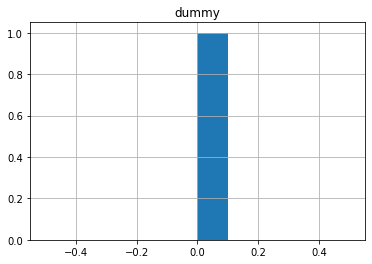

In [11]:
# Dummy data to update font size
pandas.DataFrame([0], columns = ['dummy']).hist()
matplotlib.rcParams.update({'font.size': 18})

In [12]:
def _show_hist(func, data_dir, model_name, display_name, target_tasks, ylim, xlim):
    """ Show a distribution of a metric after applying a function (func) to the sentence in the sets.
    We show the distributions of bert-only and vl model in a plot
    """
    plot = None
    
    for set_name, n, color in [
        ('bert', 'BERT-only', 'r'),
        ('vl', display_name, 'b'),
    ]:
        sentences = []
        for task in target_tasks:
            fpath = os.path.join(data_dir, f'{task}-{model_name}-{set_name}.txt'.replace('/', '_'))
            with open(fpath, 'r') as f:
                sentences.extend(line.strip() for line in f.readlines())
        
        df = pandas.DataFrame(sentences, columns = [n])
        x = df[n].apply(func)
        print(n, color, len(x), x.mean(), x.std())
        plot = x.hist(density=1, range=xlim, bins=40, alpha=0.4, color=color, legend=True)
        if ylim is not None:
            plot.set_ylim(ylim)
    
    return plot

def show_hist_fkg(data_dir, model_name, display_name, target_tasks=target_tasks, ylim=(0, 0.15), xlim=(-5, 20)):
    """metric is flesch_kincaid_grade"""
    return _show_hist(textstat.flesch_kincaid_grade, data_dir, model_name, display_name, target_tasks, ylim, xlim)

def show_hist_len(data_dir, model_name, display_name, target_tasks=target_tasks, ylim=(0, 0.020), xlim=(0, 500)):
    """metric is length"""
    return _show_hist(len, data_dir, model_name, display_name, target_tasks, ylim, xlim)

In [13]:
# Flesch kincaid grade

BERT-only r 6397 6.428607159606066 5.308449388554938
VIS-only b 3930 6.214936386768448 5.169992249612948


<AxesSubplot:>

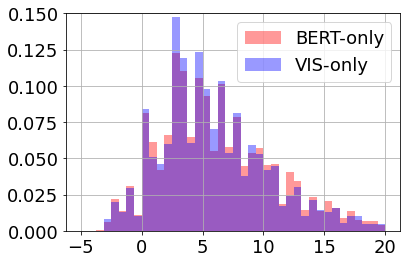

In [14]:
show_hist_fkg(output_dir, 'ctrl_visual_bert', 'VIS-only')

BERT-only r 6789 6.450508174988952 5.1894223865825015
UNI-only b 3864 6.179296066252588 5.099305422018851


<AxesSubplot:>

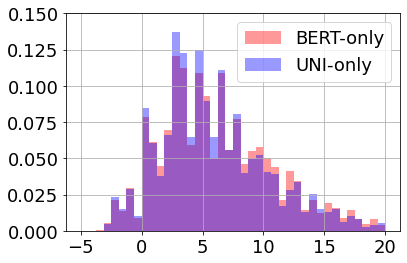

In [15]:
show_hist_fkg(output_dir, 'ctrl_uniter', 'UNI-only')

BERT-only r 6888 6.498461091753774 5.215580244684472
VL-only b 3762 6.181791600212653 5.13025037897512


<AxesSubplot:>

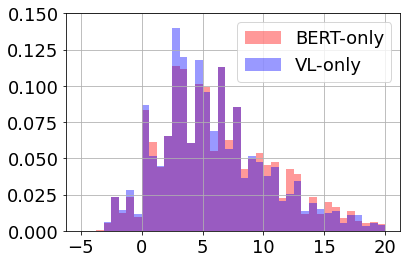

In [16]:
show_hist_fkg(output_dir, 'ctrl_vl_bert', 'VL-only')

BERT-only r 7735 6.518564964447317 5.3902860899262395
LX-only b 3979 6.290525257602413 5.126963021574092


<AxesSubplot:>

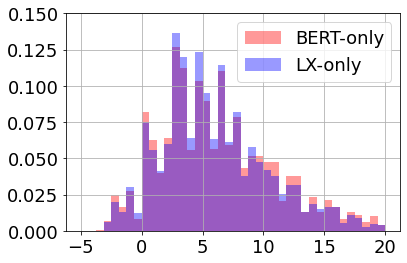

In [17]:
show_hist_fkg(output_dir, 'ctrl_lxmert', 'LX-only')

BERT-only r 8183 6.455578638641085 5.207022677773497
VIL-only b 4043 6.235938659411328 5.023145048012891


<AxesSubplot:>

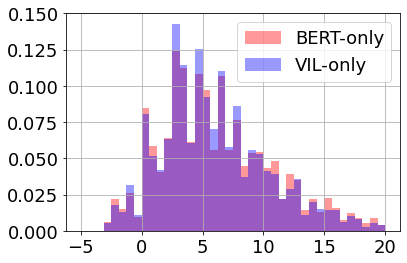

In [18]:
show_hist_fkg(output_dir, 'ctrl_vilbert', 'VIL-only')

In [19]:
# Sentence length

BERT-only r 6397 77.03751758636861 64.9670563986179
VIS-only b 3930 74.73027989821882 62.343146207307626


<AxesSubplot:>

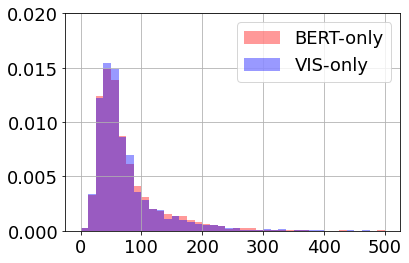

In [20]:
show_hist_len(output_dir, 'ctrl_visual_bert', 'VIS-only')

BERT-only r 6789 76.337899543379 62.11309810470672
UNI-only b 3864 74.54373706004141 61.180920214565454


<AxesSubplot:>

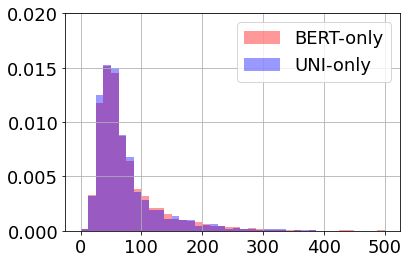

In [21]:
show_hist_len(output_dir, 'ctrl_uniter', 'UNI-only')

BERT-only r 6888 76.76132404181185 63.045731679131
VL-only b 3762 74.74534821903244 63.51734892418168


<AxesSubplot:>

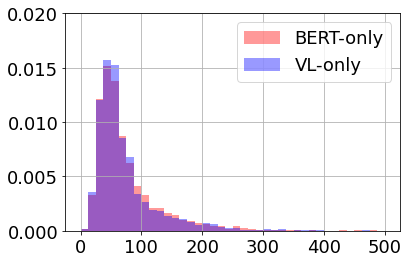

In [22]:
show_hist_len(output_dir, 'ctrl_vl_bert', 'VL-only')

BERT-only r 7735 77.65804783451843 65.41459800641302
LX-only b 3979 75.89444584066348 62.993159761878836


<AxesSubplot:>

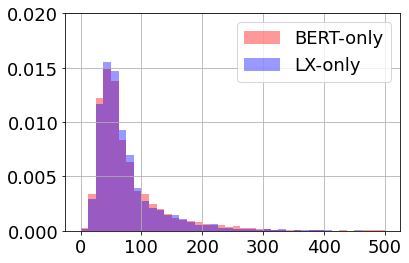

In [23]:
show_hist_len(output_dir, 'ctrl_lxmert', 'LX-only')

BERT-only r 8183 77.09275326897226 62.29826557735237
VIL-only b 4043 74.75587435072966 59.49632741397288


<AxesSubplot:>

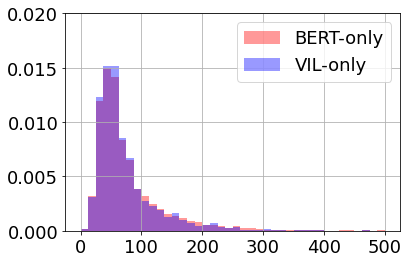

In [24]:
show_hist_len(output_dir, 'ctrl_vilbert', 'VIL-only')